In [5]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import os
import cv2
import matplotlib.pyplot as plt

In [6]:
def EncoderLayer():
    kernel = 3
    filter_size = 8
    pad = 1
    pool_size = 2
    return [
        keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),

        keras.layers.Conv2D(filter_size*2, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation ='relu'),
        keras.layers.Conv2D(filter_size*2, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation ='relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),

        keras.layers.Conv2D(filter_size*4, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(filter_size*4, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(filter_size*4, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),

        keras.layers.Conv2D(filter_size*8, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(filter_size*8, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.Conv2D(filter_size*8, kernel_size = (kernel, kernel), padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)),]

In [7]:
def DecoderLayer():
    kernel = 3
    filter_size = 8
    pad = 1
    pool_size = 2
    return [keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(filter_size*8, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filter_size*8, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filter_size*8, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            
            keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(filter_size*4, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filter_size*4, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filter_size*4, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),

            keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(filter_size*2, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filter_size*2, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            
            keras.layers.UpSampling2D(size = (pool_size,pool_size)),
            keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filter_size, kernel_size = (kernel, kernel), padding = 'same'),
            keras.layers.BatchNormalization(),]

In [8]:
## Model with original data
model = tf.keras.Sequential()
model.add(tf.keras.layers.Layer(input_shape=(256, 256,3)))
model.encoding_layers = EncoderLayer()
model.decoding_layers = DecoderLayer()
for layer in model.encoding_layers:
    model.add(layer)
for layer in model.decoding_layers:
    model.add(layer)
model.add(keras.layers.Conv2D(3,1,1, padding = 'same'))
model.add(keras.layers.Activation(activation = 'softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 8)       32        
_________________________________________________________________
activation (Activation)      (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       584       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 8)       32        
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 8)       0

In [10]:
def dataset_setup(data_dir='', n_ims=2975, offset_bias=0, img_dim=256):
    """
    Method to import the training data from CityScape and divide into image-label pairs

    Inputs
    --
    data_dir: string
        Location for the data that is being imported
    n_ims: int
        Number of images contained in the folder chosen
    offset_bias: int
        Optionally, skip some images by starting at a position further than 0
    img_dim: int
        Expected image dimension (assuming square images)

    Outputs
    --
    X: list
        Images
    y: list
        Image labels per pixel
    """

    flist = os.listdir(data_dir)
    img0 = cv2.imread(data_dir+flist[0])

    y_dim,x_dim,_ = np.shape(img0)
    X = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    y = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    
    k = 0
    for f in flist[offset_bias:offset_bias+n_ims]:
        X[k] = cv2.imread(data_dir+f)[:,:img_dim]/img_dim
        y[k] = cv2.imread(data_dir+f)[:,img_dim:]/img_dim
        
        k = k+1

    return X, y

In [22]:
# Directories containing the train and val data
train_files = "./data/cityscapes_data/train/"
val_files = "./data/cityscapes_data/val/"

# Setup image-label pairs
x, y = dataset_setup(data_dir=train_files, n_ims=2975, offset_bias=0, img_dim=256)

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)
x_test, y_test = dataset_setup(data_dir=test_files, n_ims=500, offset_bias=0, img_dim=256)

In [1]:
nb_epoch = 100
batch_size = 1
model.compile(loss="mse", optimizer='adam', metrics=['accuracy'])

NameError: ignored

In [ ]:
# trained model with original data shape (256,256,3)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epoch,verbose=1,validation_data = (x_val,y_val))

Train on 500 samples, validate on 200 samples
Epoch 1/100
500/500 [==============================] - 28s 55ms/sample - loss: 1.1269 - accuracy: 0.4234 - val_loss: 1.1041 - val_accuracy: 0.3880
Epoch 2/100
500/500 [==============================] - 25s 50ms/sample - loss: 1.1128 - accuracy: 0.4871 - val_loss: 1.0952 - val_accuracy: 0.3111
Epoch 3/100
500/500 [==============================] - 25s 50ms/sample - loss: 1.1100 - accuracy: 0.4922 - val_loss: 1.1098 - val_accuracy: 0.4371
Epoch 4/100
500/500 [==============================] - 25s 50ms/sample - loss: 1.1067 - accuracy: 0.5077 - val_loss: 1.0875 - val_accuracy: 0.4432
Epoch 5/100
500/500 [==============================] - 25s 50ms/sample - loss: 1.1042 - accuracy: 0.5133 - val_loss: 1.0940 - val_accuracy: 0.3793
Epoch 6/100
500/500 [==============================] - 25s 50ms/sample - loss: 1.1017 - accuracy: 0.5210 - val_loss: 1.0834 - val_accuracy: 0.4141
Epoch 7/100
500/500 [==============================] - 25s 50ms/sample -

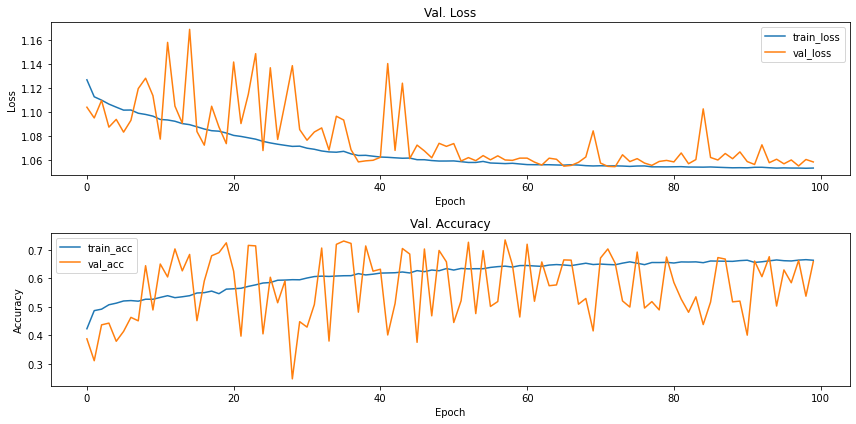

In [ ]:
#original data loss plot
loss = history.history["loss"]
acc = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Val. Loss")
plt.plot(loss,label = "train_loss")
plt.plot(val_loss,label = "val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')

plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(acc,label = "train_acc")
plt.plot(val_acc,label = "val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

plt.tight_layout()
plt.savefig("learn.png", dpi=150)
plt.show()

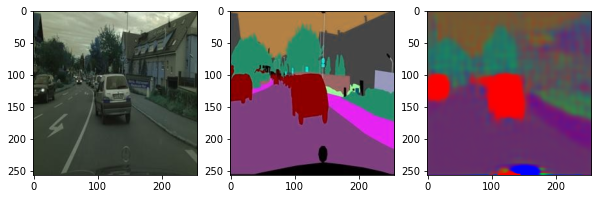

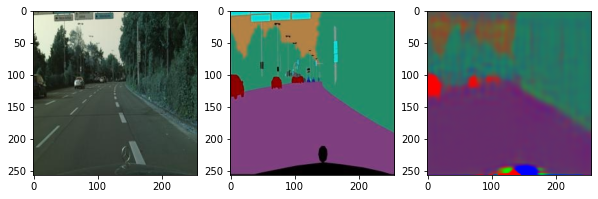

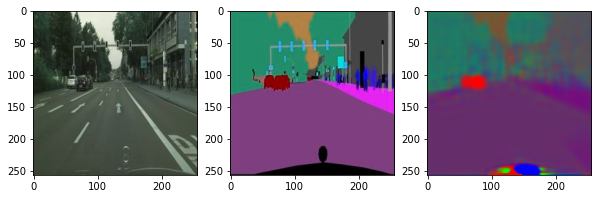

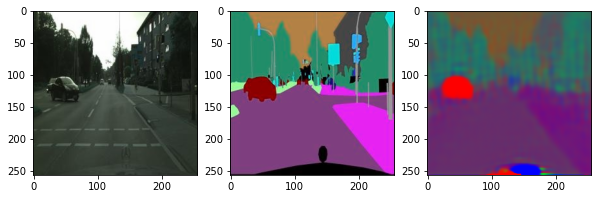

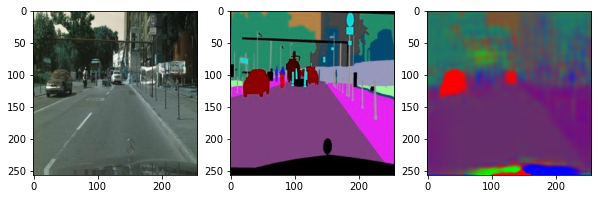

In [ ]:
#model_1 output visualization
pp = model.predict(x_val[0:5,:,:,:])
ni = 5
for k in range(ni):
    pred = LayersToRGBImage(pp[k])
    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_val[k])
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_val[k])
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pred)

In [ ]:
pp = model.predict(x_test[1,:,:,:], batch_size=1)
intersection = np.logical_and(y_test[1,:,:,:], pp)
union = np.logical_or(y_test[1,:,:,:], pp)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

In [1]:
diff = y_test[1] - pp[1] 
m_norm = np.sum(abs(diff))  
print(m_norm)
print(m_norm/(256*256))